# resolving singular learning theory of pair annihilation
Purpose: Fitting reaction range and rate parameters of linear particle model to annihilation rates of full model<br>
Tim Tyree<br>
8.16.2022

In [1]:
from lib.my_initialization import *
from lib import *
#from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.optimize import minimize
#load libraries for color bar
import matplotlib as mpl #for colorbar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda
# import scanpy as sc
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#     theme=cuxfilter.themes.dark
#     #     theme=cuxfilter.themes.rapids
else:
    sns.set_style('white')
#     theme=cuxfilter.themes.light
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#reset matplotlib settings
from mpltools import annotation
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [3]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)
print_dict(wjr)

fk_pbc lr_pbc fk_ncbc lr_ncbc
fk_pbc={'m': 1.8772341309722325, 'Delta_m': 0.02498750277237229, 'M': 5.572315674840435, 'Delta_M': 0.3053120355191732, 'b': 1.665608066257863, 'Delta_b': 0.029341409948945123}
lr_pbc={'m': 1.6375562704001745, 'Delta_m': 0.017190912126700632, 'M': 16.73559858353835, 'Delta_M': 0.8465090320196467, 'b': 2.86877101880514, 'Delta_b': 0.0311865277365552}
fk_ncbc={'m': 1.854156794480594, 'Delta_m': 0.024531267275222507, 'b': 1.9249840368187936, 'Delta_b': 0.033016842409840354, 'Rsquared': 0.9960514654423748, 'M': 7.135532649256891, 'Delta_M': 0.4454472504725109}
lr_ncbc={'m': 1.6611400039209039, 'Delta_m': 0.026856157147378743, 'b': 2.8636688985503183, 'Delta_b': 0.055411463888674725, 'Rsquared': 0.9873700703980065, 'M': 16.75061667963681, 'Delta_M': 1.2837944679833377}


In [4]:
from isosurfaces import plot_isosurface
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# define module

In [5]:
def comp_rmse_powerlaw(df,M,m,dq=0.05,q_values=None):
    """
    Example Usage:
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_24_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)
df = comp_rmse_powerlaw(df,q_values,M,m,dq=0.05)
df.sort_values(by='rmse',inplace=True)
df['rmse'].values
    """
    if q_values is None:
        #compute q_values used by df
        q_min = df.q_min.drop_duplicates().values[0]
        q_max = df.q_max.drop_duplicates().values[0]
        q_values=np.arange(q_min,q_max,dq)
        
    #input: m,M, q_values used by df
    #output: w_values
    w_values=M*q_values**m

    #compute rmse for each row
    df['rmse']=np.nan
    for i,row in df.iterrows():
        m_ = row['m']
        M_ = row['M']
        w_values_linear=M_*q_values**m_
        df.loc[i,'rmse']= np.sqrt(np.mean((w_values_linear-w_values)**2))
    return df

In [6]:
def load_cached_powerlaw_fits_linear_particle(input_fn,
                            neighbor=1,      #1: forces are computed between nearest neighbors only
                            reflect=0,       #0: periodic boundary conditions
                            force_code=2,    #2: 1/R attractive force
                            set_second=0,    #0: dont set within range
                            no_attraction=0, #0: attraction is permitted
                            no_repulsion=0,  #0: repulsion is permitted (warning: alinear<0 is prohibitively slow)
                            pos_D_only=True, #selects only positive D if true
                            printing=True,
                            **kwargs):
    """
    Example Usage:
input_fn=f"{nb_dir}/data/osg_output/run_25_all_powerlaw_fits.csv"
dg=load_cached_powerlaw_fits_linear_particle(input_fn,neighbor=1)
    """
    df=pd.read_csv(input_fn)
    if printing:
        print(f"loading from src: {input_fn=}...")

        print(f"\nnum. alinear values considered: {len(sorted(df['varkappa'].drop_duplicates().values))}")
        print(f"parameter range:")
        print(df.describe()[['r','kappa','varkappa','D','L']].T[['min','max']].T)

    scale_invariant_descr_str = f"""
    coordinates: 'length scale invariant coordinates dual to mean pair-annihilation rate in the linear particle model'
        - x1=r       / L
        - x2=kappa
        - x3=alinear / (L**2)
        - x4=D       / (L**2)
    """
    if printing:
        print(scale_invariant_descr_str)
    #compute the scale invariant coordinates
    df['x1']=df['r']/df['L']
    df['x2']=df['kappa']
    df['x3']=df['varkappa']/(df['L']**2)
    df['x4']=df['D']/(df['L']**2)
    # xlabel=r'$r/L$'
    # # ylabel=r'$1/\kappa$ (s)'
    # ylabel=r'$\kappa$ (Hz)'
    # zlabel=r'$a_{Linear}/L^2$ (Hz)'
    if printing:
        print(f"scale-invariant parameter range:")
        print(df.describe()[['x1','x2','x3','x4']].T[['min','max']].T)

    # print(f"\n\n(more details:)")
    # print(df.describe().T[['min','max']].T)

    #query the DataFrame
    query =(df.set_second==set_second)&(df.reflect==reflect)
    query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
    query&=(df.neighbor==neighbor)&(df.force_code==force_code)
    if pos_D_only:
        query&=df.D>0
    dg=df[query]
    
    if printing:
        num_rows_selected = dg.shape[0]
        num_rows_total = df.shape[0]
        print(f"{num_rows_selected=} out of {num_rows_total}")
    return dg

In [7]:
def get_interp_magnitude_defect(interp,x4,M):
    """
    Example Usage:
interp_magnitude_defect = get_interp_magnitude_defect(interp,x4,M)
defect = interp_magnitude_defect(x)
    """
    def interp_magnitude_defect(x):    
        x1,x2,x3=x
        xx=(x1,x2,x3,x4)
        yhat=interp(xx)
        Mhat=yhat[0]
        #mhat=yhat[1]
        return Mhat-M
    return interp_magnitude_defect

def get_interp_exponent_defect(interp,x4,nu):
    """
    Example Usage:
interp_exponent_defect = get_interp_exponent_defect(interp,x4,nu)
defect = interp_exponent_defect(x)
    """
    def interp_exponent_defect(x):    
        x1,x2,x3=x
        xx=(x1,x2,x3,x4)
        yhat=interp(xx)
        #Mhat=yhat[0]
        mhat=yhat[1]
        return mhat-nu
    return interp_exponent_defect


# DONE: aggregate linear interpolating function from cached results

In [8]:
#############################
# load cached powerlaw fits
#############################
#DONE: merge many runs
#DONE: search for any more runs to merge with
# neighbor=0
# input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv"  #zero selected (neighbors=0)
# input_fn=f"{nb_dir}/data/osg_output/run_18_all_powerlaw_fits.csv" #zero selected (neighbors=0)

neighbor=1
input_fn_lst=[
#     f"{nb_dir}/data/osg_output/run_19_all_powerlaw_fits.csv", #nonzero selected #interpolates? #this one broke it #linear, perhaps
#     f"{nb_dir}/data/osg_output/run_20_all_powerlaw_fits.csv", #too low varkappa #nonzero selected #this one broke it #linear, perhaps
# #     f"{nb_dir}/data/osg_output/run_21_all_powerlaw_fits.csv", #too low varkappa #nonzero selected #this one broke it #oscillatory, perhaps
# #     f"{nb_dir}/data/osg_output/run_22_all_powerlaw_fits.csv", #too low varkappa #nonzero selected #this one broke it #oscillatory, perhaps
# #     f"{nb_dir}/data/osg_output/run_23_all_powerlaw_fits.csv", #too low varkappa #nonzero selected #this one broke it #oscillatory, perhaps
    f"{nb_dir}/data/osg_output/run_24_all_powerlaw_fits.csv", #nonzero selected #interpolates
    f"{nb_dir}/data/osg_output/run_25_all_powerlaw_fits.csv" #nonzero selected #interpolates
]  

#TODO: try selecting D>0 only
count=0
for i,fn in enumerate(input_fn_lst):
    df=pd.read_csv(fn)
    num_rows=df.shape[0]
    print(f"fn: {os.path.basename(fn)}, len: {num_rows}")
    count+=num_rows
print(count)

fn: run_24_all_powerlaw_fits.csv, len: 4239
fn: run_25_all_powerlaw_fits.csv, len: 17640
21879


In [9]:
# fn: run_24_all_powerlaw_fits.csv, len: 4239
# fn: run_25_all_powerlaw_fits.csv, len: 17640
# 21879

In [10]:
#DONE: aggregate list of sessions
printing=False
dg_lst=[]
for input_fn in input_fn_lst:
    dg=load_cached_powerlaw_fits_linear_particle(input_fn,neighbor=int(neighbor),printing=printing)
    if dg.shape[0]>0:
        dg_lst.append(dg)
    else:
        print(f"Warning: no rows selected from {input_fn=}")
df_powerlaw_fits=pd.concat(dg_lst)
df_powerlaw_fits.reset_index(inplace=True,drop=False)
print(f"successfully merged {len(dg_lst)} input files!")
df_powerlaw_fits.shape

successfully merged 2 input files!


(21879, 29)

In [344]:
num_obs = df_powerlaw_fits.shape[0]
num_obs

21879

In [345]:
saving=True
# powerlaw_fits_dir=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbor_{neighbor}.csv"
powerlaw_fits_dir=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbor_{neighbor}_numobs_{num_obs}.csv"
print(f"{powerlaw_fits_dir=}")
if saving:
    df_powerlaw_fits.to_csv(powerlaw_fits_dir,index=False)

powerlaw_fits_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbor_1_numobs_21879.csv'


# TODO: generate lookup table for linear interpolating function of direct simulation of the linear particle model

In [348]:
Rsq_min=0.98
#recall results

# # #run 19 with 20 #Rsq min is 0.93 before filtering...
# # powerlaw_fits_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbor_1_numobs_18715.csv'
# powerlaw_fits_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbor_1_numobs_19965.csv'# 

# # run 19 with 20, 24, 25  #Rsq min is 0.89 before filtering...
# powerlaw_fits_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbor_1_numobs_41844.csv'

# #run 24, 25  #Rsq min is 0.89 before filtering...
# powerlaw_fits_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbor_1_numobs_21879.csv'

# powerlaw_fits_dir=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbor_{neighbor}.csv"
df_powerlaw_fits=pd.read_csv(powerlaw_fits_dir)
#TODO: filter any bad fits
print(f"{df_powerlaw_fits['Rsq'].min()=}, {df_powerlaw_fits.shape}")
df_powerlaw_fits = df_powerlaw_fits[df_powerlaw_fits['Rsq']>=Rsq_min].\
    reset_index(drop=True).copy()
print(f"{df_powerlaw_fits['Rsq'].min()=}, {df_powerlaw_fits.shape}")
df_powerlaw_fits.describe().T[['min','max']]

df_powerlaw_fits['Rsq'].min()=0.8949494344261261, (21879, 29)
df_powerlaw_fits['Rsq'].min()=0.9800395995426732, (20972, 29)


,min,max
index,0.000000,17639.000000
m,1.373735,5.864135
Delta_m,0.018717,0.509114
M,1.191753,2301.625941
Delta_M,0.053949,2806.828886
Rsq,0.980040,0.999933
rmse,0.009421,47.928614
rmse_full,0.087425,509.976374
q_min,0.240000,0.240000
q_max,0.700000,0.750000


In [350]:
#filter by D,a as positive
df_powerlaw_fits = df_powerlaw_fits[df_powerlaw_fits['Rsq']>=Rsq_min].\
    reset_index().copy()#19 with 20, 19 with 20, 

ValueError: cannot insert level_0, already exists

In [169]:
#####################
# compute interp map
#####################
dg = df_powerlaw_fits.copy()
rescale=True#False
testing=True
#define parameters to be varied
# input_cols=['r','D','varkappa']#
# input_cols=['r','kappa','varkappa','D']#
input_cols=['x1','x2','x3','x4']#
# output_cols=['m','Delta_m','M','Delta_M']#2 minute runtime
output_cols=['m','M']#2.75 minute runtime paradoxically...
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_cols].values

X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')
# print(f"estimated runtime is ~{20+120*int(testing)} seconds...")
print(f"estimated runtime is ~{4*len(input_fn_lst)} minutes...")
interp = LinearNDInterpolator(X, y, rescale=rescale)
print(f"training complete!")
if testing:
    num_test=100
    yhat = interp(X[:num_test])
    print(f"shape of X {X[:num_test].shape} --> shape of y=yhat {yhat.shape}")
    rmse=np.sqrt(np.mean((yhat-y[:num_test])**2))
    print(f"the rmse of simple interpolation is {rmse:.4f}")

number of training examples is 18715.
estimated runtime is ~8 minutes...
training complete!
shape of X (100, 4) --> shape of y=yhat (100, 2)
the rmse of simple interpolation is 0.0000


In [170]:
x1=0.03
x2=200. #Hz 
x3=0.01 #Hz 
x4=0.01 #Hz 
x=(x1,x2,x3,x4)
yhat=interp(x)
yhat
# array([ 2.67847876, 25.93927313])

array([ 2.67847876, 25.93927313])

# TODO: visualize isosurfaces in the scale-invariant dual basis of the linear particle model.
- with M given, fixed
- with nu given, fixed

In [172]:
# M=wjr['fk_pbc']['M']
# m=wjr['fk_pbc']['m']
# # M=wjr['lr_pbc']['M']
# # m=wjr['lr_pbc']['m']

In [355]:
#extract coordinates for area bounds
x1_values=df_powerlaw_fits['x1'].values # ~ r
x2_values=df_powerlaw_fits['x2'].values # ~ kappa
x3_values=df_powerlaw_fits['x3'].values # ~ alinear
x4_values=df_powerlaw_fits['x4'].values # ~ D

#define bounds of surface plot for magnitude equal to M
x1lim=[np.min(x1_values),np.max(x1_values)]
x2lim=[np.min(x2_values),np.max(x2_values)]
x3lim=[np.min(x3_values),np.max(x3_values)]
x4lim=[np.min(x4_values),np.max(x4_values)]
pmin = np.array([x1lim[0], x2lim[0], x3lim[0]])
pmax = np.array([x1lim[1], x2lim[1], x3lim[1]])

print (f"bounding box:")
print (f"{x1lim=}\t(r/L)")
print (f"{x2lim=}\t(kappa?)")
print (f"{x3lim=}\t(alinear/L^2)")
print (f"{x4lim=}\t(D/L^2)")

bounding box:
x1lim=[0.002, 0.3399999999999999]	(r/L)
x2lim=[10, 990]	(kappa?)
x3lim=[0.0621199999999999, 0.39876]	(alinear/L^2)
x4lim=[0.0036, 0.00456]	(D/L^2)


In [357]:
# #FK 200x200, diffCoeff=0.001
# # src: TT
# alinear=1.12
# D=.365
# # src: wjr
# M=5.57# +/- (30)
# nu=1.877# +/- (25)
# L=5

# #didn't work...
# #LR 200x200, diffCoeff=0.0005
# # src: TT
# alinear=2.76 
# D=0.58
# # src: wjr
# M=16.73# +/- (84)
# nu=1.638# +/- (17)
# L=5

In [356]:
#TODO: fix interp_magnitude(x1,x2,x3,x4) to an observed value from the full model

# #FK 200x200, diffCoeff=0.0005, src: WJ
# alinear=1.553
# D=0.114
# M=2.7 # +/- (1.3)
# nu=0.84 # +/- (17)
# L=5

#LR 200x200, diffCoeff=0.001, src: WJ
alinear=9.969
D=0.09
M=12.6 # +/- (3.8)
nu=1.20 # +/- (8)
L=5

In [358]:
x4 = D/L/L
interp_magnitude_defect = get_interp_magnitude_defect(interp,x4,M)
interp_exponent_defect = get_interp_exponent_defect(interp,x4,nu)

## scatter plot the volume cube for either defect interpolating function

In [359]:
#define bounds of surface plot for magnitude equal to M
# x1lim,x2lim,x3lim
#heretimheretim
print (f"bounding box:")
print (f"{x1lim=}\t(r/L)")
print (f"{x2lim=}\t(kappa?)")
print (f"{x3lim=}\t(alinear/L^2)")
print (f"{x4lim=}\t(D/L^2)")

bounding box:
x1lim=[0.002, 0.3399999999999999]	(r/L)
x2lim=[10, 990]	(kappa?)
x3lim=[0.0621199999999999, 0.39876]	(alinear/L^2)
x4lim=[0.0036, 0.00456]	(D/L^2)


In [308]:
#generate scatterplot data for volume cube
grid_lcount=100
x1=np.linspace(x1lim[0],x1lim[1],grid_lcount)
x2=np.linspace(x2lim[0],x2lim[1],grid_lcount)
x3=np.linspace(x3lim[0],x3lim[1],grid_lcount)
# arg_arr=np.stack((x1,x2,x3)).T
# arg_arr.shape
xi=[x1,x2,x3]
u1,u2,u3=np.meshgrid(*xi)
u1=u1.flatten()
u2=u2.flatten()
u3=u3.flatten()
dM_lst=[]
dnu_lst=[]
# for uu1,uu2,uu3 in zip(u1,u2,u3):
# for args in zip(u1,u2,u3):
for args in reversed(list(zip(u1,u2,u3))):
    pass

In [360]:
# args

In [310]:
# interp_magnitude_defect(args)

TypeError: interp_magnitude_defect() takes 1 positional argument but 3 were given

In [361]:
grid_lcount=100
x1=np.linspace(x1lim[0],x1lim[1],grid_lcount)
x2=np.linspace(x2lim[0],x2lim[1],grid_lcount)
x3=np.linspace(x3lim[0],x3lim[1],grid_lcount)
x4=np.linspace(x4lim[0],x4lim[1],grid_lcount)
arg_arr=np.stack((x1,x2,x3,x4)).T
arg_arr.shape

(100, 4)

In [362]:
xi=[x1,x2,x3,x4]
arg_arr=np.meshgrid(*xi)
arg_arr[0].shape

(100, 100, 100, 100)

In [363]:
#heretim
# Make a mesh in the space of parameterisation variables u and v
u = np.linspace(0, 2.0 * np.pi, endpoint=True, num=50)
v = np.linspace(-0.5, 0.5, endpoint=True, num=10)
u, v = np.meshgrid(u, v)
u, v = u.flatten(), v.flatten()

NameError: name 'func' is not defined

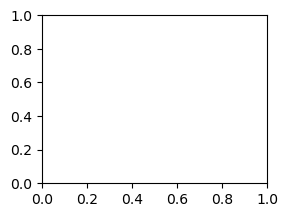

In [364]:
import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

In [294]:
interp(arg_arr)

array([[         nan,          nan],
       [         nan,          nan],
       [  1.4663136 ,   2.87006823],
       [  1.4259234 ,   3.67235445],
       [  1.40542397,   4.40826822],
       [  1.40627013,   5.47848302],
       [  1.40055567,   6.17058709],
       [  1.40325828,   7.17738743],
       [  1.4019584 ,   7.99394017],
       [  1.417942  ,   8.91281332],
       [  1.47666109,   9.62811329],
       [  1.52105038,  10.51781427],
       [  1.54250465,  11.28352349],
       [  1.58927223,  12.02750409],
       [  1.68854962,  12.63363914],
       [  1.75678222,  13.24476905],
       [  1.72014677,  14.5032562 ],
       [  1.76811684,  15.30810589],
       [  1.77458654,  16.82452014],
       [  1.80637061,  17.58131701],
       [  1.80668495,  19.00243445],
       [  1.81436526,  20.25541103],
       [  1.85304399,  21.36463757],
       [  1.84454823,  23.1868277 ],
       [  1.8845425 ,  24.58594791],
       [  1.85815454,  25.28035535],
       [  1.89155801,  26.77957759],
 

In [292]:
interp(arg_arr.T)

ValueError: number of dimensions in xi does not match x

In [290]:
interp_magnitude_defect(arg_arr)

ValueError: too many values to unpack (expected 3)

In [ ]:
#TODO: compute the color values
# cvec=interp_magnitude_defect()
interp_magnitude_defect()

In [ ]:
# def interp_magnitude_defect(x):    
#         x1,x2,x3=x
#         xx=(x1,x2,x3,x4)
#         yhat=interp(xx)
#         Mhat=yhat[0]
#         #mhat=yhat[1]
#         return Mhat-M

In [ ]:
#TODO: define and normalize a diverging color map with 0 centered at 0

In [ ]:
#TODO: scatter plot some discretization

## plot the isolines

In [365]:
#define bounds of surface plot for magnitude equal to M
# x1lim,x2lim,x3lim
#heretimheretim
print (f"bounding box:")
print (f"{x1lim=}\t(r/L)")
print (f"{x2lim=}\t(kappa?)")
print (f"{x3lim=}\t(alinear/L^2)")
print (f"{x4lim=}\t(D/L^2)")

bounding box:
x1lim=[0.002, 0.3399999999999999]	(r/L)
x2lim=[10, 990]	(kappa?)
x3lim=[0.0621199999999999, 0.39876]	(alinear/L^2)
x4lim=[0.0036, 0.00456]	(D/L^2)


In [366]:
#estimate the magnitude isosurface from the linear interpolator
min_depth=5
min_depth=2
max_cells=10000
max_cells=64
simplices, faces = plot_isosurface(interp_magnitude_defect, 
                            pmin=pmin, 
                            pmax=pmax,  
                            min_depth=min_depth, 
                            max_cells=max_cells)

In [266]:
#TODO: test that faces exist
assert not faces==list()
beep(7)

AssertionError: 

In [ ]:
# Q: did ^that work?
# heretim

In [224]:
num_faces=len(faces)
num_simplices=len(simplices) #not immediately useful
shp=np.array(faces[0]).shape #faces appear to be a triangle with 3 coordinate values for each vertex
#test all faces are same dimensionality (triangles in 3 dimensions)
for face in faces:
    assert shp==shp
print(f"tested all faces are of shape, {shp}.")
print(f"{num_faces=}")

IndexError: list index out of range

In [ ]:
#collapse all faces into a set of xyz triples
vert_lst=[]
for face in faces:
    for vert in face:
        vert_lst.append(vert)
# vert_set=set(sorted(vert_lst) #fast but destructive and unecessary
vert_set=set(vert_lst)
#format ibid as numpy.array instance
vertices = np.array(list(vert_set))
vertices.shape

In [ ]:
#TODO: compute vertex index array with one triangular face per row
#TODO(bonus): generate a numpy.array instance of ints indexing the faces
#indexing int maps to vertex in vertices


In [ ]:
#TODO: plot surface in 3D

In [197]:
#TODO: plot magnitude defect
fig = plt.figure(figsize=plt.figaspect(0.5))
ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
#TODO: format_plot
plt.show()

ValueError: x and y must be equal-length 1D arrays

<Figure size 960x480 with 0 Axes>

In [ ]:
# dnu_hat=nan
# dnu_hat=nan
# dnu_hat=nan
# dnu_hat=2.8834698272332107
# dnu_hat=nan
# dnu_hat=38.48232835903418
# dnu_hat=33.643018641851825
# dnu_hat=437.569586444785

# dnu_hat=nan
# dnu_hat=nan
# dnu_hat=nan
# dnu_hat=2.8834698272332098
# dnu_hat=433.4022168892278
# dnu_hat=38.48232835903418
# dnu_hat=33.64301864185182
# dnu_hat=437.569586444785

In [183]:
#TODO: goal: get 3d surface plotted for both 


#TODO: root cause analysis as to why i'm getting 
# dg.shape,dg.dropna().shape, dg['m'].dropna().shape
# dg[dg.isnull()]
dg.describe()

,level_0,index,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,...,reflect,set_second,no_repulsion,no_attraction,x1,x2,x3,x4,dt,Dt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
#estimate the exponent isosurface from the linear interpolator
simplices2, faces2 = plot_isosurface(interp_exponent_defect, 
                            pmin=pmin, 
                            pmax=pmax, 
                            min_depth=min_depth, 
                            max_cells=max_cells,
                                    tol=0.1)

AssertionError: 

In [ ]:
#heretim

<module 'matplotlib.tri' from '/home/timothytyree/miniconda3/envs/pyenv_ub/lib/python3.9/site-packages/matplotlib/tri/__init__.py'>

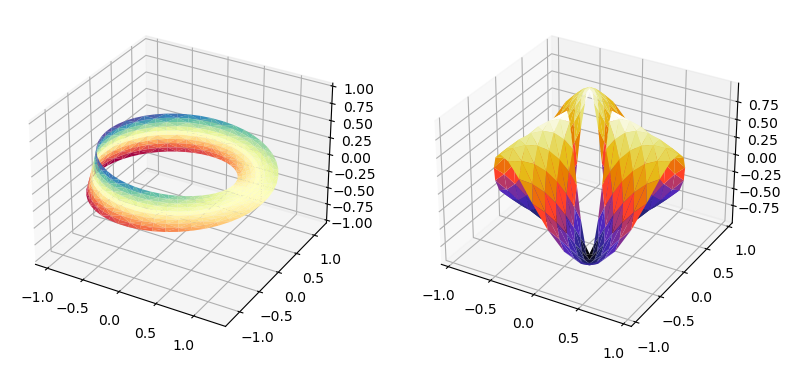

In [127]:
fig = plt.figure(figsize=plt.figaspect(0.5))
# ==========
# First plot
# ==========
# Make a mesh in the space of parameterisation variables u and v
u = np.linspace(0, 2.0 * np.pi, endpoint=True, num=50)
v = np.linspace(-0.5, 0.5, endpoint=True, num=10)
u, v = np.meshgrid(u, v)
u, v = u.flatten(), v.flatten()
# This is the Mobius mapping, taking a u, v pair and returning an x, y, z
# triple
x = (1 + 0.5 * v * np.cos(u / 2.0)) * np.cos(u)
y = (1 + 0.5 * v * np.cos(u / 2.0)) * np.sin(u)
z = 0.5 * v * np.sin(u / 2.0)
# Triangulate parameter space to determine the triangles
tri = mtri.Triangulation(u, v)
# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
ax.set_zlim(-1, 1)
# ===========
# Second plot
# ===========
# Make parameter spaces radii and angles.
n_angles = 36
n_radii = 8
min_radius = 0.25
radii = np.linspace(min_radius, 0.95, n_radii)
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi/n_angles

# Map radius, angle pairs to x, y, z points.
x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()
z = (np.cos(radii)*np.cos(3*angles)).flatten()

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = mtri.Triangulation(x, y)

# Mask off unwanted triangles.
xmid = x[triang.triangles].mean(axis=1)
ymid = y[triang.triangles].mean(axis=1)
mask = xmid**2 + ymid**2 < min_radius**2
triang.set_mask(mask)

# Plot the surface.
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(triang, z, cmap=plt.cm.CMRmap)


plt.show()

## scratchwerk

In [60]:
metaball_pts = [np.array([0, 1.6, 0]), np.array([0, -1.6, 0])]

def fn(p):
    # metaballs
    # return sum(1 / np.linalg.norm(p - q) for q in metaball_pts) - 1
    # cone with singularity at origin
    return p[0] ** 2 + p[1] ** 2 - p[2] ** 2

pmin = np.array([-4, -4, -4])
pmax = np.array([4, 4, 4])
simplices, faces = plot_isosurface(fn, pmin, pmax, 2, 64)
# faces = list(faces)

In [ ]:
#heretim
#TODO: dev projection from the isosurface to x,y,z values
#TODO: compute the isosurface for M
#TODO: compute the isosurface for nu

In [103]:
#TODO: figure out how to plot an isosurface
simp=simplices[0][0]
simp.pos
import trimesh
# vert = np.loadtxt('/home/timothytyree/Documents/GitHub/care/notebooks/membrane-notebooks/Data/pt85_RA_vert')
# faces = np.loadtxt('/home/timothytyree/Documents/GitHub/care/notebooks/membrane-notebooks/Data/pt85_RA_faces')
# faces = faces - 1 #fix: 1 to 0 indexing
# mesh = trimesh.Trimesh(vertices=vert,
#                        faces=faces)
mesh = trimesh.Trimesh(vertices=faces,
                       faces=simplices)
mesh.show()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'ValuedPoint'

In [117]:
type(simplices[1][0].val)

numpy.float64

In [118]:
len(simplices),len(simplices[0])

(5376, 4)

In [ ]:
#face.get_dual(self.fn), <-- that's what we want

In [ ]:
#TODO: map simplex to dict_simplex
#TODO: map faces to a numpy array faces/vertices
#TODO: visualize the surface with trimesh
# isosurface | trimesh
# simplex    | faces = a list of triples of indices indexing vertices.
# faces      | vertices = a list of vertices.

In [120]:
len(simplices[0])

4

In [121]:
import isosurfaces

In [ ]:
isosurfaces.

In [115]:
pos_lst.append(simplices[1][0].pos)
simplices[1][0].val

9.0

In [ ]:
np.concatenate(pos_lst)
np.concatenate(val_lst)

In [109]:
isosurfaces.point.ValuedPoint

Object `isosurfaces.point.ValuedPoint` not found.


In [106]:
simplices[0]

[(-3.0,-3.0; 9.0), (-4.0,-3.0; 16.0), (-4.0,-4.0; 23.0), (-4.0,-4.0; 16.0)]

In [97]:

fontsize=12
num_samples = 1000
marker='o'
alpha=0.6
markersize=150
#DONE: plot the point cloud using the simplest possible method from matplotlib
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# # plot the plane of fixed alinear
# # TODO: color plane by c_values interpolated to surface
# ax.plot_surface(xx, yy, z_obs, alpha=0.1)
# plot the plane of fixed alinear
# TODO: color plane by c_values interpolated to surface
ax.plot_surface(xx, yy, z_obs, alpha=0.1)


#format_plot
xlabel=r'$r/L$'
# ylabel=r'$1/\kappa$ (s)'
ylabel=r'$\kappa$ (Hz)'
zlabel=r'$a_{Linear}/L^2$ (Hz)'
ax.set_xlabel(xlabel,fontsize=fontsize)
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_zlabel(zlabel,fontsize=fontsize)
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.set_zlim(zlim)
ax.set_title(r'With $D/L^2$'+f'={x4:.4f} Hz',fontsize=fontsize)
plt.show()

In [96]:
M,nu

(12.6, 1.2)

In [86]:
#TODO: estimate the exponent isosurface from the linear interpolator


# TODO: dev viewer

In [14]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A']*10**3 #Hz/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A']*10**3 #Hz/cm^2

In [11]:
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_18_all_powerlaw_fits.csv"
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_15_all_powerlaw_fits.csv" #works for many parameter settings (L=10)
dff=pd.read_csv(input_fn)
dff.head()
dff.describe().T[['min','max']].T[['varkappa','D','L']]
# np.array(sorted(dff.varkappa.drop_duplicates().values))

,varkappa,D,L
min,1.0,0.0,10.0
max,110.0,0.8,10.0


In [15]:
#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()

# input_fn=f"{nb_dir}/data/osg_output/run_15_all_powerlaw_fits.csv"
input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv" #works for many (L=10)
L=10
mode='vectorsummed'
# input_fn=f"{nb_dir}/data/osg_output/run_25_all_powerlaw_fits.csv" # (L=5)
# L=5
# mode='neighboronly'

input_fn_dict={'vectorsummed':input_fn,'neighboronly':input_fn}
interp=recall_particle_model_interp(input_fn_dict=input_fn_dict,L=L,mode=mode)
# interp=recall_particle_model_interp(input_fn_dict=input_fn_dict)

estimated runtime is ~20 seconds for 17988 training samples...
number of training examples is 17988....
training complete!


In [18]:
#200x200, diffCO0ff=0.0005, (FK) (src: WJ)
a=1.553  
D=.114

# #200x200, diffCO0ff=0.001, (FK) (src: TT)
# a=1.12  *4
# D=.365   *4

model_name='fk_pbc'#;c='C0'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']



q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
args=a,D,q_values,w_values,interp
if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=M_full
# nu=nu_full
what_values=M*q_values**nu

q_values_fk=q_values.copy()
what_values_fk=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (FK) fit to {M=}, {nu=}")
dict_fk=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=1.553, D=0.114, r=0.055995618375196024, kappa=600.0003359088596, rmse=0.016286700173075413 (FK) fit to M=5.5997315550892965, nu=1.9066517727219523


In [20]:
# #victor for LR: SMS with GammaBar computed from the average of all spiral tip observations
# # SMS:a=9.60637, D=0.586055, r=0.11865725394705823, kappa=453.30813258922205, rmse=0.031175747845115034 (LR)
# ahat=9.60637#rmse=0.031175747845115034 (LR)
# # ahat=7.28148 #rmse=0.16022186827576143 (LR)
# # MS:
# # ahat=4.99485 # rmse=0.4555348657752726 (LR)
# # ahat=7.13454# rmse=0.17979087126721505 (LR)
# a=ahat;
# a=a_hat_LR
# D=D_hat_LR     #^those

# LR 200x200, diffCoeff=0.001 (src: WJ)
a=9.969
D=0.09     
# a=9.969    *4
# D=0.09     *4

# # #LR 200x200, diffCoeff=0.0005 (src: WJ)
# a=2.767   
# D=0.58    

# a=a_hat_LR;D=D_hat_LR #rmse=0.028075538795257697 (LR)
model_name='lr_pbc'#;c='C1'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)
#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu
q_values_lr=q_values.copy()
what_values_lr=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (LR) fit to {M=}, {nu=}")
dict_lr=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=9.969, D=0.09, r=0.10058359731826436, kappa=586.9003694162833, rmse=0.010526946048031557 (LR) fit to M=16.718488654328976, nu=1.632170058210073


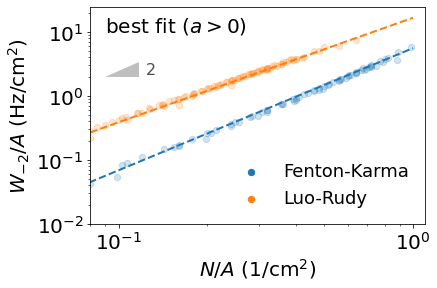

(9.969, 16.718488654328976, 1.632170058210073)

In [21]:
#plot the best fits when a>0
fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
xytext=(0.09, 10)
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

#plot the full models
ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

#plot the result over the original annihilation rates
plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)

#format
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$N/A$ (1/cm$^{2}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
ax.annotate(r"best fit ($a>0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

#mark the slope of ^that line with ~2
x1 = 0.09
y1 = 2
annotation.slope_marker(origin=(x1, y1),
                        slope=2,
                        text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                        poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
                        ax=ax)
# #mark the slope of ^that line with ~3
# x1 = 0.6
# y1 = 0.3
# annotation.slope_marker(origin=(x1, y1),
#                         slope=3,#(3, 1),
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
plt.show()
# print(dict_fk)
# print(dict_lr)
a,M,nu

## TODO: generate a dataframe full of fits to full. compute scale invariant parameter settings, and list the good fits

In [22]:
model_name='lr_pbc'#;c='C1'
D=0.09*4
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

In [23]:
# a_values=np.arange(1,40,1)
# a_values=np.arange(7,14,0.5)
a_values=np.arange(7,14,0.1)
dict_fit_lst=[]
for a in a_values:
    #find a best r,kappa pair for a given a,D pair for a given full model
    args=a,D,q_values,w_values,interp
    bnds = ((1e-3, 2), (1e2, 1e4))
    x0 = (0.1, 500)
    # res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
    res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
    mse=comp_mse_via_interp(res.x, *args)
    rmse=np.sqrt(mse)
    #compute the resulting annihilation rates
    r=res.x[0]
    kappa=res.x[1]
    X=np.array([[r,kappa,a,D]])
    yhat = interp(X)
    nu=yhat[0,0]
    M=yhat[0,1]
    what_values=M*q_values**nu
    q_values_lr=q_values.copy()
    what_values_lr=what_values.copy()
    #print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (LR) fit to {M=}, {nu=}")
    # dict_lr=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)
    dict_fit=dict(a=a,D=D,r=r,kappa=kappa,nu=nu,M=M,rmse=rmse)
    #record
    dict_fit_lst.append(dict_fit)
df_fit_lr=pd.DataFrame(dict_fit_lst)

In [24]:
model_name='fk_pbc'#;c='C1'
D=0.114*4 #*4 to account for L=5 --> L=10
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

In [25]:
# a_values=np.arange(1,40,1)
# a_values=np.arange(1,4,0.1)
a_values=np.arange(1,4,0.02)
dict_fit_lst=[]
for a in a_values:
    #find a best r,kappa pair for a given a,D pair for a given full model
    args=a,D,q_values,w_values,interp
    bnds = ((1e-3, 2), (1e2, 1e4))
    x0 = (0.1, 500)
    # res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
    res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
    mse=comp_mse_via_interp(res.x, *args)
    rmse=np.sqrt(mse)
    #compute the resulting annihilation rates
    r=res.x[0]
    kappa=res.x[1]
    X=np.array([[r,kappa,a,D]])
    yhat = interp(X)
    nu=yhat[0,0]
    M=yhat[0,1]
    what_values=M*q_values**nu
    q_values_lr=q_values.copy()
    what_values_lr=what_values.copy()
    #print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (LR) fit to {M=}, {nu=}")
    # dict_lr=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)
    dict_fit=dict(a=a,D=D,r=r,kappa=kappa,nu=nu,M=M,rmse=rmse)
    #record
    dict_fit_lst.append(dict_fit)
df_fit_fk=pd.DataFrame(dict_fit_lst)

In [26]:
L=10
df_fit_fk['x1']=df_fit_fk['r']/L
df_fit_fk['x2']=1/df_fit_fk['kappa']
df_fit_fk['x3']=df_fit_fk['a']/L**2
df_fit_lr['x1']=df_fit_lr['r']/L
df_fit_lr['x2']=1/df_fit_lr['kappa']
df_fit_lr['x3']=df_fit_lr['a']/L**2

xlabel=r'$r/L$'
ylabel=r'$1/\kappa$ (s)'
# ylabel=r'$\kappa$ (Hz)'
zlabel=r'$a_{Linear}/L^2$ (Hz)'

In [34]:
#extract desired plot points
# rmse_max=0.25
rmse_max=0.25
df_fit = df_fit_fk[df_fit_fk['rmse']<=rmse_max].copy()
# df_fit = df_fit_fk.copy()
x1_values_fk=df_fit['x1'].values
x2_values_fk=df_fit['x2'].values
x3_values_fk=df_fit['x3'].values
c_values_fk =df_fit['rmse'].values

df_fit = df_fit_lr[df_fit_lr['rmse']<=rmse_max].copy()
# df_fit = df_fit_lr.copy()
x1_values_lr=df_fit['x1'].values
x2_values_lr=df_fit['x2'].values
x3_values_lr=df_fit['x3'].values
c_values_lr =df_fit['rmse'].values


In [35]:
# DONE: compute c_values interpolated to surface
xlim=[0,0.02]
ylim=[0,0.02]
zlim=[0,0.15]
# zlim=[0,0.5]
# xlim=[0.005, 0.05]
# ylim=[0.0006666666666666666, 0.01]
# zlim=[0.01, 1.1]

# xx, yy = np.meshgrid(np.linspace(ylim[0],ylim[1],10),np.linspace(xlim[0],xlim[1],10))
xx, yy = np.meshgrid(np.linspace(xlim[0],xlim[1],10),np.linspace(ylim[0],ylim[1],10))


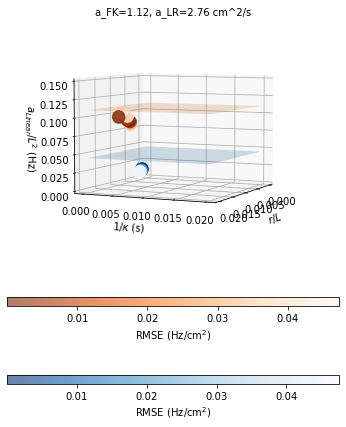

indicated is (shaded plane) alinear1=2.76 cm^2/s (LR)
indicated is (shaded plane) alinear2=1.12 cm^2/s (FK)


In [36]:
fontsize=10
num_samples = 1000
marker='o'
alpha=0.6
markersize=150
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=5., azim=25)
#plot the approximate of the singular learning theory
c1=ax.scatter(x1_values_fk,x2_values_fk,x3_values_fk,c=c_values_fk,
           marker=marker,alpha=alpha,s=markersize,cmap='Blues_r')
c2=ax.scatter(x1_values_lr,x2_values_lr,x3_values_lr,c=c_values_lr,
           marker=marker,alpha=alpha,s=markersize,cmap='Oranges_r')
#add formated colorbar
# fontsize=14
fraction=0.07
shrink=0.85
aspect=35
orientation='horizontal'

cbar_label=r'RMSE (Hz/cm$^2$)'
cax, kw = mpl.colorbar.make_axes_gridspec(ax, orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink, aspect=aspect)
cbar=fig.colorbar(c1, cax=cax, orientation=orientation)#,cmap=cmap)#,norm=norm)##, extend='max')#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)

cax, kw = mpl.colorbar.make_axes_gridspec(ax, orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink, aspect=aspect)
cbar=fig.colorbar(c2, cax=cax, orientation=orientation)#,cmap=cmap)#,norm=norm)##, extend='max')#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)

# plot the plane of fixed alinear
# TODO: color plane by c_values interpolated to surface
# alinear1=9.969
L_=5
# L_=10
alinear1=2.76
z_obs = 0.*xx - 0.*yy + alinear1/(L_**2)
ax.plot_surface(xx, yy, z_obs, alpha=0.2,color='C1')

# alinear2=1.553
alinear2=1.12
z_obs = 0.*xx - 0.*yy + alinear2/(L_**2)
ax.plot_surface(xx, yy, z_obs, alpha=0.2,color='C0')

title=f'a_FK={alinear2}, a_LR={alinear1} cm^2/s'

#format_plot
# zlim=[0,0.1]
ax.set_xlabel(xlabel,fontsize=fontsize)
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_zlabel(zlabel,fontsize=fontsize)
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
ax.set_title(title,fontsize=fontsize)
ax.set_zlim(zlim)
plt.show()
print(f"indicated is (shaded plane) {alinear1=} cm^2/s (LR)")
print(f"indicated is (shaded plane) {alinear2=} cm^2/s (FK)")

In [38]:
#DONE: determine reasonable bounds for r and kappa for run #26
rmse_max=0.05
df_fit = df_fit_fk[df_fit_fk['rmse']<=rmse_max].copy()
df_fit[['r','kappa']].describe().T[['min','max']]

,min,max
r,0.050000,0.067000
kappa,476.793577,623.483606


In [39]:
rmse_max=0.05
df_fit = df_fit_lr[df_fit_lr['rmse']<=rmse_max].copy()
df_fit[['r','kappa']].describe().T[['min','max']]

,min,max
r,0.088305,0.173811
kappa,259.873907,679.263519


In [33]:
# kappa from 200 to 1000
# r from 0.02 to 0.2

,min,max
r,0.05,0.137321
kappa,100.00,623.483606


In [ ]:
#heretim
#TODO: approximate the singular learning theory with scatter plots

In [ ]:
#heretim
#GOAL: visualize slt
#DONE: grid search over a for estimating r,kappa,rmse holding D fixed

#TODO: scatter plot all a,D values with rmse<0.1 in the scale invariant parameter representation
#DONE: plot the point cloud using the simplest possible method from matplotlib
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#load libraries for color bar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
fontsize=12
num_samples = 1000
marker='o'
alpha=0.6
markersize=150
# markersize=300
# xlim=[0.005, 0.05]
# ylim=[0.00066, 0.01]
# zlim=[0.01, 1.1]

vmin=None
vmax=None
#create a continuous norm to map from data points to colors
if vmin is None:
    vmin=c_values.min()
if vmax is None:
    vmax=c_values.max()
norm = plt.Normalize(vmin, vmax)

# ax.set_title(title_str,fontsize=fontsize)
ax.set_title(title_str,fontsize=fontsize+8)
# cmap='viridis'
# ax.scatter(x_values,y_values,z_values,marker=marker,alpha=alpha,s=markersize,cmap=cmap,c=c_values)
ax.scatter(x_values_selected,y_values_selected,z_values_selected,
           c=c_values_selected,
           marker=marker,alpha=alpha,s=markersize,cmap=cmap)
#format_plot
ax.set_xlabel(xlabel,fontsize=fontsize)
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_zlabel(zlabel,fontsize=fontsize)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.show()
print(f"indicated is (shaded plane) {alinear=} cm^2/s.")

# TODO(later): simple scatter plot of the where the fit is best using the Boltzman distribution, as before.
- with M given, fixed
- with nu given, fixed
- least square loss regression

In [ ]:
M=wjr['fk_pbc']['M']
m=wjr['fk_pbc']['m']
# M=wjr['lr_pbc']['M']
# m=wjr['lr_pbc']['m']

In [ ]:
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_24_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_25_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all_powerlaw_fits.csv"
powerlaw_fits_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/powerlaw_fits_aggregated_neighbors_1.csv'
input_fn=str(powerlaw_fits_dir)
print(f"{input_fn=}")
df=pd.read_csv(input_fn)
df = comp_rmse_powerlaw(df,M=M,m=m,dq=0.05)
# df = comp_rmse_powerlaw(df,q_values,M,m,dq=0.05)
df.sort_values(by='rmse',inplace=True)
df['rmse'].values

In [ ]:
#DONE: plot the point cloud using the simplest possible method from matplotlib
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#load libraries for color bar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
fontsize=12
num_samples = 1000
marker='o'
alpha=0.6
markersize=150
# markersize=300
# xlim=[0.005, 0.05]
# ylim=[0.00066, 0.01]
# zlim=[0.01, 1.1]

vmin=None
vmax=None
#create a continuous norm to map from data points to colors
if vmin is None:
    vmin=c_values.min()
if vmax is None:
    vmax=c_values.max()
norm = plt.Normalize(vmin, vmax)

# ax.set_title(title_str,fontsize=fontsize)
ax.set_title(title_str,fontsize=fontsize+8)
# cmap='viridis'
# ax.scatter(x_values,y_values,z_values,marker=marker,alpha=alpha,s=markersize,cmap=cmap,c=c_values)
ax.scatter(x_values_selected,y_values_selected,z_values_selected,
           c=c_values_selected,
           marker=marker,alpha=alpha,s=markersize,cmap=cmap)

booD=D_values_selected>0
ax.scatter(x_values_selected[booD],y_values_selected[booD],z_values_selected[booD],
           c=c_values_selected[booD],
           marker='^',alpha=alpha,s=markersize,cmap=cmap)


# N = 100
# X, Y = np.mgrid[-3:3:complex(0, N), -2:2:complex(0, N)]
# # A low hump with a spike coming out of the top right.  Needs to have
# # z/colour axis on a log scale so we see both hump and spike.  linear
# # scale only shows the spike.
# Z1 = np.exp(-X**2 - Y**2)
# Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
# Z = Z1 + 50 * Z2

# # fig, ax = plt.subplots(2, 1)
norm=colors.LogNorm(vmin=vmin, vmax=vmax)
# pcm = ax[0].pcolor(X, Y, Z,
#                    norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
#                    cmap='PuBu_r', shading='auto')
# fig.colorbar(pcm, ax=ax[0], extend='max')


#plot color bar
# fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
# cmap='PuBu_r'
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
#vertical color bar
# # cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# cax = plt.axes([0.85, 0.2, 0.025, 0.65])
# plt.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax=cax,label='RMSE of w(q) (Hz)',extend='max')
#horizontal color bar
w=.3
h=.25
cax = plt.axes([0.25, 0, 0.25+w, -0.2+h])
plt.colorbar(ScalarMappable(norm=norm, cmap=cmap),cax=cax,label='RMSE of w(q) (Hz)',extend='max',
            orientation="horizontal", pad=0.)#,textsize=fontsize)#,

# plot the plane of fixed alinear
# TODO: color plane by c_values interpolated to surface
ax.plot_surface(xx, yy, z_obs, alpha=0.1)


#format_plot
ax.set_xlabel(xlabel,fontsize=fontsize)
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_zlabel(zlabel,fontsize=fontsize)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
plt.show()
print(f"indicated is (shaded plane) {alinear=} cm^2/s.")

# demonstration of local extrema by sign of parametric defect

In [196]:
#NOTE: linear program is apparently not working for sign test...
#COROLLARY: --> supports desired manifold supporting local maxima for both target parameters (M,nu)
def test_interp_defect_3d_crosses_zero(foo,x1lim,x2lim,x3lim,printing=True):
    """test that dnu crosses zero somewhere before looking for manifolds where dnu crosses zero using linear programming...
    Example Usage:
has_positive,has_negative = test_interp_defect_3d_crosses_zero(interp_exponent_defect,x1lim,x2lim,x3lim)#,printing=True)
assert (has_positive)
assert (has_negative)
    """
    interp_exponent_defect = foo
    has_positive=False
    has_negative=False
    dnu_hat = interp_exponent_defect(x=np.array([x1lim[0], x2lim[0], x3lim[0]]))
    if printing: print(f"{dnu_hat=}")
    has_positive |= dnu_hat>0
    has_negative |= dnu_hat<0
    dnu_hat = interp_exponent_defect(x=np.array([x1lim[1], x2lim[0], x3lim[0]]))
    if printing: print(f"{dnu_hat=}")
    has_positive |= dnu_hat>0
    has_negative |= dnu_hat<0
    dnu_hat = interp_exponent_defect(x=np.array([x1lim[0], x2lim[1], x3lim[0]]))
    if printing: print(f"{dnu_hat=}")
    has_positive |= dnu_hat>0
    has_negative |= dnu_hat<0
    dnu_hat = interp_exponent_defect(x=np.array([x1lim[0], x2lim[0], x3lim[1]]))
    if printing: print(f"{dnu_hat=}")
    has_positive |= dnu_hat>0
    has_negative |= dnu_hat<0
    dnu_hat = interp_exponent_defect(x=np.array([x1lim[1], x2lim[1], x3lim[0]]))
    if printing: print(f"{dnu_hat=}")
    has_positive |= dnu_hat>0
    has_negative |= dnu_hat<0
    dnu_hat = interp_exponent_defect(x=np.array([x1lim[1], x2lim[0], x3lim[1]]))
    if printing: print(f"{dnu_hat=}")
    has_positive |= dnu_hat>0
    has_negative |= dnu_hat<0
    dnu_hat = interp_exponent_defect(x=np.array([x1lim[0], x2lim[1], x3lim[1]]))
    if printing: print(f"{dnu_hat=}")
    has_positive |= dnu_hat>0
    has_negative |= dnu_hat<0
    dnu_hat = interp_exponent_defect(x=np.array([x1lim[1], x2lim[1], x3lim[1]]))
    has_positive |= dnu_hat>0
    has_negative |= dnu_hat<0
    if printing: print(f"{dnu_hat=}")
    return has_positive,has_negative

print(f"magnitude:")
# test that dM crosses zero somewhere before looking for manifolds where dM crosses zero using linear programming...
has_positive,has_negative = test_interp_defect_3d_crosses_zero(interp_magnitude_defect,x1lim,x2lim,x3lim)#,printing=True)
# assert (has_positive)#fails
# assert (has_negative)#fails
print(f"\nexponent:")
# test that dnu crosses zero somewhere before looking for manifolds where dnu crosses zero using linear programming...
has_positive,has_negative = test_interp_defect_3d_crosses_zero(interp_exponent_defect,x1lim,x2lim,x3lim)#,printing=True)
# assert (has_positive)#fails
# assert (has_negative)#fails

magnitude:
dnu_hat=nan
dnu_hat=nan
dnu_hat=nan
dnu_hat=-11.26965356438363
dnu_hat=nan
dnu_hat=-10.982641211213961
dnu_hat=-11.209296292367823
dnu_hat=-10.594962190337373

exponent:
dnu_hat=nan
dnu_hat=nan
dnu_hat=nan
dnu_hat=2.8834698272332107
dnu_hat=nan
dnu_hat=38.48232835903418
dnu_hat=33.643018641851825
dnu_hat=437.569586444785


# TODO: generate a reasonably spaced subsample of the singular learning theory

- --> dev next run_26 with these values (just save to .csv and load it from .csv in ../bgmc/c/attractive/src/ and print them, as before.)<br>
`../bgmc/c/attractive/src/`

# i don't think scipy.ndimage.map_coordinates is worth spending too much time on...

In [272]:
# # scipy.ndimage.map_coordinates?
# from inspect import getsource
# print(getsource(scipy.ndimage.map_coordinates))

In [273]:
# @docfiller
# def map_coordinates(input, coordinates, output=None, order=3,
#                     mode='constant', cval=0.0, prefilter=True):
#     """
#     Map the input array to new coordinates by interpolation.

#     The array of coordinates is used to find, for each point in the output,
#     the corresponding coordinates in the input. The value of the input at
#     those coordinates is determined by spline interpolation of the
#     requested order.

#     The shape of the output is derived from that of the coordinate
#     array by dropping the first axis. The values of the array along
#     the first axis are the coordinates in the input array at which the
#     output value is found.

#     Parameters
#     ----------
#     %(input)s
#     coordinates : array_like
#         The coordinates at which `input` is evaluated.
#     %(output)s
#     order : int, optional
#         The order of the spline interpolation, default is 3.
#         The order has to be in the range 0-5.
#     %(mode_interp_constant)s
#     %(cval)s
#     %(prefilter)s

#     Returns
#     -------
#     map_coordinates : ndarray
#         The result of transforming the input. The shape of the output is
#         derived from that of `coordinates` by dropping the first axis.

#     See Also
#     --------
#     spline_filter, geometric_transform, scipy.interpolate

#     Notes
#     -----
#     For complex-valued `input`, this function maps the real and imaginary
#     components independently.

#     .. versionadded:: 1.6.0
#         Complex-valued support added.

#     Examples
#     --------
#     >>> from scipy import ndimage
#     >>> a = np.arange(12.).reshape((4, 3))
#     >>> a
#     array([[  0.,   1.,   2.],
#            [  3.,   4.,   5.],
#            [  6.,   7.,   8.],
#            [  9.,  10.,  11.]])
#     >>> ndimage.map_coordinates(a, [[0.5, 2], [0.5, 1]], order=1)
#     array([ 2.,  7.])

#     Above, the interpolated value of a[0.5, 0.5] gives output[0], while
#     a[2, 1] is output[1].

#     >>> inds = np.array([[0.5, 2], [0.5, 4]])
#     >>> ndimage.map_coordinates(a, inds, order=1, cval=-33.3)
#     array([  2. , -33.3])
#     >>> ndimage.map_coordinates(a, inds, order=1, mode='nearest')
#     array([ 2.,  8.])
#     >>> ndimage.map_coordinates(a, inds, order=1, cval=0, output=bool)
#     array([ True, False], dtype=bool)

#     """
#     if order < 0 or order > 5:
#         raise RuntimeError('spline order not supported')
#     input = numpy.asarray(input)
#     coordinates = numpy.asarray(coordinates)
#     if numpy.iscomplexobj(coordinates):
#         raise TypeError('Complex type not supported')
#     output_shape = coordinates.shape[1:]
#     if input.ndim < 1 or len(output_shape) < 1:
#         raise RuntimeError('input and output rank must be > 0')
#     if coordinates.shape[0] != input.ndim:
#         raise RuntimeError('invalid shape for coordinate array')
#     complex_output = numpy.iscomplexobj(input)
#     output = _ni_support._get_output(output, input, shape=output_shape,
#                                      complex_output=complex_output)
#     if complex_output:
#         kwargs = dict(order=order, mode=mode, prefilter=prefilter)
#         map_coordinates(input.real, coordinates, output=output.real,
#                         cval=numpy.real(cval), **kwargs)
#         map_coordinates(input.imag, coordinates, output=output.imag,
#                         cval=numpy.imag(cval), **kwargs)
#         return output
#     if prefilter and order > 1:
#         padded, npad = _prepad_for_spline_filter(input, mode, cval)
#         filtered = spline_filter(padded, order, output=numpy.float64,
#                                  mode=mode)
#     else:
#         npad = 0
#         filtered = input
#     mode = _ni_support._extend_mode_to_code(mode)
#     _nd_image.geometric_transform(filtered, None, coordinates, None, None,
#                                   output, order, mode, cval, npad, None, None)
#     return output